Archivo cargado. Shape: (1092, 20)
Columnas numéricas: ['FechaDocumento', 'Pico_0_B_M_A_TOP', 'Pico_B_M_A', 'EsFechaNomina', 'EsMayor2M', 'EsFinSemana', 'TotalVentaNeta', 'VentaContado', 'VentaCredito', 'UnidadesKit', 'TotalDsctos', 'Gramos', 'VentasNORTE', 'VentasOCCIDENTE', 'VentasCENTROORIENTE', 'Dolar', 'IPC', 'EsPicoAumetado', 'ESPicoBinary', 'EsFechaEspecial']

Top features seleccionadas (por |corr|):
1. TotalVentaNeta_lag1 (|corr|=0.5326)
2. TotalVentaNeta (|corr|=1.0000)
3. VentaContado (|corr|=1.0000)
4. Gramos (|corr|=0.9246)
5. UnidadesKit (|corr|=0.9227)
6. VentasCENTROORIENTE (|corr|=0.8672)
7. Pico_0_B_M_A_TOP (|corr|=0.7679)
8. Pico_B_M_A (|corr|=0.7621)

Total muestras: 1092, entrenamiento: 982, prueba: 110

Métricas (conjunto prueba):
Linear Regression -> R2: 1.0000, MSE: 0.0000, MAE: 0.0000
Random Forest    -> R2: 0.9955, MSE: 23604932975.1291, MAE: 26791.9053


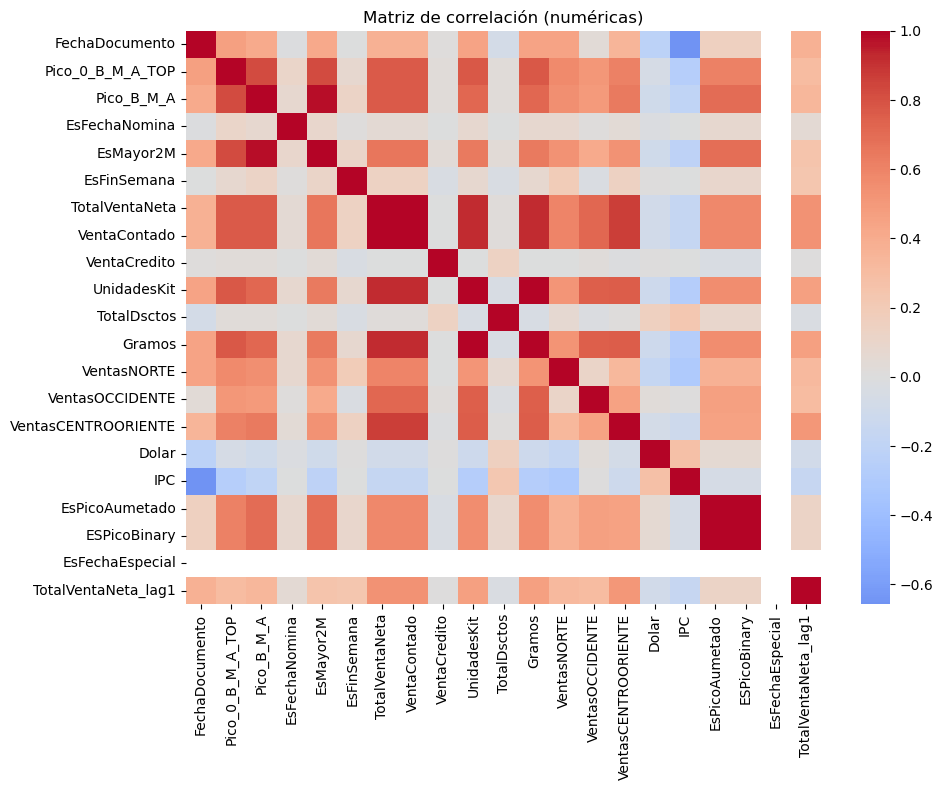

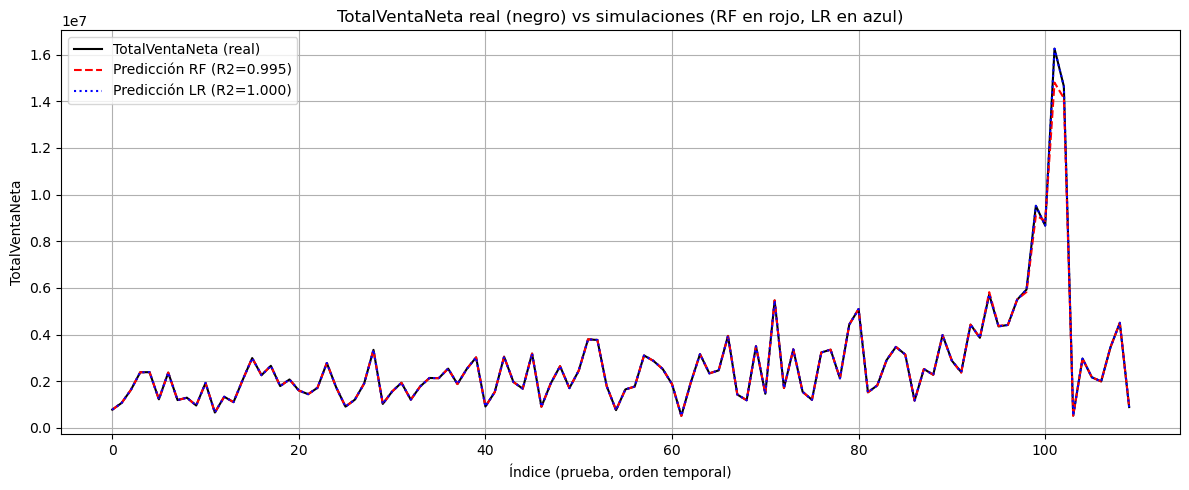


Ecuación del modelo lineal (escala original):
TotalVentaNeta = -0.000000 + (-0.000000)*TotalVentaNeta_lag1 + (+1.000000)*TotalVentaNeta + (-0.000000)*VentaContado + (-0.000000)*Gramos + (+0.000000)*UnidadesKit + (+0.000000)*VentasCENTROORIENTE + (+0.000000)*Pico_0_B_M_A_TOP + (+0.000000)*Pico_B_M_A


In [1]:
# analiza_ventas_sindy_like.py
# Requisitos: pandas, numpy, scikit-learn, matplotlib, seaborn
# pip install pandas numpy scikit-learn matplotlib seaborn

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# -------------------- AJUSTA RUTA DEL CSV --------------------
csv_path = "../ERP-POS-Data/Sales-CSV970-1093.csv"   # <-- coloca aquí la ruta correcta si no está en el mismo directorio

# 1) Cargar CSV (detecta separador ';' que suele usar tu archivo)
try:
    df = pd.read_csv(csv_path, sep=';', encoding='utf-8', low_memory=False)
except Exception:
    df = pd.read_csv(csv_path, encoding='utf-8', low_memory=False)

print("Archivo cargado. Shape:", df.shape)

# 2) Comprobar existencia de la variable objetivo
target = "TotalVentaNeta"
if target not in df.columns:
    raise ValueError(f"No se encontró la columna objetivo '{target}'. Columnas disponibles: {list(df.columns)}")

# 3) Seleccionar columnas numéricas
df_num = df.select_dtypes(include=[np.number]).copy()
print("Columnas numéricas:", df_num.columns.tolist())

# 4) Crear lag(1) de la variable objetivo para capturar dinámica autoregresiva
df_num['TotalVentaNeta_lag1'] = df_num[target].shift(1)

# 5) Imputar valores faltantes (NaN) con la mediana de cada columna
df_num = df_num.fillna(df_num.median())

# 6) Selección de features: elegir top-k por correlación absoluta con el target
all_feats = [c for c in df_num.columns if c != target]
corrs = df_num[all_feats + [target]].corr()[target].abs().sort_values(ascending=False)
k = 8
top_features = corrs.index[:k].tolist()
# Asegurar que lag1 esté incluido (es valioso para dinámica)
if 'TotalVentaNeta_lag1' not in top_features:
    top_features = ['TotalVentaNeta_lag1'] + [f for f in top_features if f!='TotalVentaNeta_lag1'][:k-1]

print("\nTop features seleccionadas (por |corr|):")
for i,f in enumerate(top_features,1):
    print(f"{i}. {f} (|corr|={corrs.get(f):.4f})")

# 7) Construir X,y preservando orden temporal y crear split 90/10
X = df_num[top_features].values
y = df_num[target].values
n = len(df_num)
split = int(0.9 * n)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(f"\nTotal muestras: {n}, entrenamiento: {len(X_train)}, prueba: {len(X_test)}")

# 8) Escalado para la regresión lineal
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# 9) Entrenar modelos: Lineal y Random Forest
lr = LinearRegression().fit(X_train_s, y_train)
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1).fit(X_train, y_train)

# 10) Predicciones sobre test
y_pred_lr = lr.predict(X_test_s)
y_pred_rf = rf.predict(X_test)   # RF usa escala original de X

# 11) Métricas
def metrics(y_true, y_pred):
    return {
        "R2": r2_score(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred)
    }
metrics_lr = metrics(y_test, y_pred_lr)
metrics_rf = metrics(y_test, y_pred_rf)

print("\nMétricas (conjunto prueba):")
print("Linear Regression -> R2: {:.4f}, MSE: {:.4f}, MAE: {:.4f}".format(metrics_lr['R2'], metrics_lr['MSE'], metrics_lr['MAE']))
print("Random Forest    -> R2: {:.4f}, MSE: {:.4f}, MAE: {:.4f}".format(metrics_rf['R2'], metrics_rf['MSE'], metrics_rf['MAE']))

# 12) Mostrar matriz de correlación (heatmap)
plt.figure(figsize=(10,8))
corr_matrix = df_num.corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title("Matriz de correlación (numéricas)")
plt.tight_layout()
plt.show()

# 13) Mostrar gráfica: TotalVentaNeta real (negro) y simulación RF (rojo)
plt.figure(figsize=(12,5))
plt.plot(range(len(y_test)), y_test, color='black', label='TotalVentaNeta (real)')
plt.plot(range(len(y_test)), y_pred_rf, color='red', linestyle='--', label=f'Predicción RF (R2={metrics_rf["R2"]:.3f})')
plt.plot(range(len(y_test)), y_pred_lr, color='blue', linestyle=':', label=f'Predicción LR (R2={metrics_lr["R2"]:.3f})')
plt.xlabel("Índice (prueba, orden temporal)")
plt.ylabel("TotalVentaNeta")
plt.title("TotalVentaNeta real (negro) vs simulaciones (RF en rojo, LR en azul)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 14) Mostrar la ecuación del modelo lineal en escala original (interpretable)
coef_scaled = lr.coef_              # coef. sobre features escaladas
scale = scaler.scale_
mean = scaler.mean_
coef_original = coef_scaled / scale
intercept_original = lr.intercept_ - np.sum(coef_scaled * mean / scale)
print("\nEcuación del modelo lineal (escala original):")
equation_terms = " + ".join([f"({coef_original[i]:+.6f})*{top_features[i]}" for i in range(len(top_features))])
print(f"TotalVentaNeta = {intercept_original:+.6f} + {equation_terms}")

# 15) Tablas de salida: coeficientes e importancias
coef_df = pd.DataFrame({"feature": top_features, "coef_scaled": coef_scaled, "coef_original": coef_original}).round(6)
rf_imp = pd.Series(rf.feature_importances_, index=top_features).sort_values(ascending=False).round(6)


